# LDA 個案實作

## 載入相關套件

In [1]:
from sklearn import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1. 載入資料

In [2]:
ds = datasets.load_wine()
df = pd.DataFrame(ds.data, columns=ds.feature_names)
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


## 2. 資料清理、資料探索與分析

In [3]:
# 資料集說明
print(ds.DESCR)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            10.6  30.0    19.5   3.3
    Ma

## 3. 資料分割

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 指定X、Y
X = df.values
y = ds.target

# 資料分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

# 查看陣列維度
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((142, 13), (36, 13), (142,), (36,))

## 4. 特徵縮放

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

## 進行特徵萃取

In [6]:
# 計算 S_W, S_B 散佈矩陣
def calculate_SW_SB(X, y, label_count):
    mean_vecs = []
    for label in range(label_count):
        mean_vecs.append(np.mean(X[y == label], axis=0))
        print(f'Class {label} Mean = {mean_vecs[label]}')
        
    d = X.shape[1]  # number of features
    S_W = np.zeros((d, d))
    for label, mv in zip(range(label_count), mean_vecs):
        class_scatter = np.cov(X[y == label].T)
        S_W += class_scatter
    print(f'Sw shape:{S_W.shape}')

    mean_overall = np.mean(X, axis=0)
    S_B = np.zeros((d, d))
    for i, mean_vec in enumerate(mean_vecs):
        n = X[y == i + 1, :].shape[0]
        mean_vec = mean_vec.reshape(d, 1)  # make column vector
        mean_overall = mean_overall.reshape(d, 1)  # make column vector
        S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)
    print(f'Sb shape:{S_B.shape}')
    return S_W, S_B

In [7]:
# LDA 函數實作
def LDA_numpy(X, X_test, y, label_count, no):
    S_W, S_B = calculate_SW_SB(X, y, label_count)
    # 計算特徵值(eigenvalue)及對應的特徵向量(eigenvector)
    eigen_val, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))
    # 合併特徵向量及特徵值
    eigen_pairs = [(np.abs(eigen_val[i]), eigen_vecs[:,i]) for i in 
                   range(len(eigen_vecs))]
    print('Eigenvalues in descending order:\n')
    for eigen_val in eigen_pairs:
        print(eigen_val[0])
    
    # 針對特徵值降冪排序
    eigen_pairs.sort(key=lambda x: x[0], reverse=True)

    w = eigen_pairs[0][1][:, np.newaxis].real
    for i in range(1, no):
        w = np.hstack((w, eigen_pairs[i][1][:, np.newaxis].real))

    # 轉換：矩陣相乘 (n, m) x (m, 2) = (n, 2)
    return X.dot(w), X_test.dot(w)

X_train_pca, X_test_pca = LDA_numpy(X_train_std, X_test_std, y_train, 
                                    len(ds.target_names), 2) # 取 2 個特徵
X_train_pca.shape, X_test_pca.shape

Class 0 Mean = [ 0.98405916 -0.26911282  0.27483548 -0.83543345  0.56539602  0.89102161
  0.96129863 -0.60309683  0.55717302  0.21926832  0.45963151  0.81472721
  1.24847548]
Class 1 Mean = [-0.86189949 -0.40835522 -0.36630132  0.22586693 -0.40496489  0.01629366
  0.11519264 -0.00781963  0.12332682 -0.82689352  0.44469859  0.25727006
 -0.70692822]
Class 2 Mean = [ 2.41010919e-01  9.24952943e-01  2.60516760e-01  5.73631345e-01
 -3.62456762e-04 -1.00747561e+00 -1.23711281e+00  6.76983112e-01
 -8.04052537e-01  1.03038650e+00 -1.19092488e+00 -1.29408906e+00
 -2.88942366e-01]
Sw shape:(13, 13)
Sb shape:(13, 13)
Eigenvalues in descending order:

354.71337639725846
65.80969305948722
3.772402957468869e-14
3.772402957468869e-14
2.4130612370554442e-14
2.4130612370554442e-14
1.6622945058157507e-14
1.6622945058157507e-14
1.2191956768298743e-14
3.404701791538851e-15
3.404701791538851e-15
2.1165640813811297e-15
2.1165640813811297e-15


((142, 2), (36, 2))

## 5. 選擇演算法

In [8]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

## 6. 模型訓練

In [9]:
clf.fit(X_train_pca, y_train)

LogisticRegression()

## 7. 模型計分

In [10]:
# 計算準確率
y_pred = clf.predict(X_test_pca)
print(f'{accuracy_score(y_test, y_pred)*100:.2f}%') 

100.00%


## 繪製決策邊界(Decision regions)

In [11]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    color=cmap(idx),
                    marker=markers[idx], 
                    label=cl)

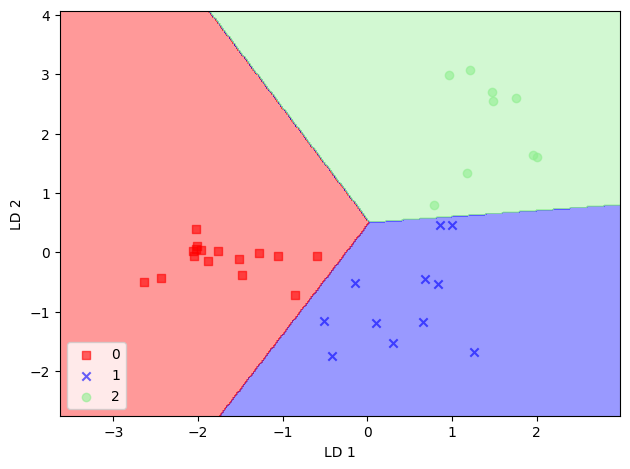

In [12]:
plot_decision_regions(X_test_pca, y_test, classifier=clf)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('decision_regions.png', dpi=300)
plt.show()

## 使用全部特徵

In [13]:
# 載入資料集
X, y = datasets.load_wine(return_X_y=True)

# 資料分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

# 查看陣列維度
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# 特徵縮放
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# 模型訓練
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X_train_std, y_train)

# 模型計分
y_pred = clf.predict(X_test_std)
print(f'{accuracy_score(y_test, y_pred)*100:.2f}%') 

(142, 13) (36, 13) (142,) (36,)
97.22%
